In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/home/penthotal/Desktop/website_bazaar/posts/generic_posts':
  os.chdir(r'/home/penthotal/Desktop/website_bazaar/posts/generic_posts')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/tmp/ipykernel_21580/2394929718.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/importlib/_bootstrap.py": 1686421844.1239913, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/importlib/_bootstrap_external.py": 1686421844.1199913, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/zipimport.py": 1686421843.3719742, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/codecs.py": 1686421843.0919678, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/encodings/aliases.py": 1686421843.667981, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/encodings/__init__.py": 1686421843.7679832, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/encodings/utf_8.py": 1686421843.8759856, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/abc.py": 1686421843.059967, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/io.py": 1686421843.1759696, "/home/penthotal/mambaforge-pypy3/envs/jax_env/lib/python3.11/stat.py": 1686421843.2999725

In [2]:
#| code-fold: true
#| code-summary: "Show supplementary code"
from typing import Tuple, List, Any

from functools import partial

import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE

from jax.typing import ArrayLike
from jax.random import KeyArray
from jax.lax import scan
from jax import vmap
from jax import numpy as jnp
from jax import random, jit
from jax.scipy.linalg import inv

import matplotlib.pyplot as plt

@jit
def tempered_softmax(logits, temperature=1):
    """Produce a tempered softmax given logits.

    Args:
        logits (ArrayLike): logits to be turned into probability.
        temperature (int, optional): parameter controlling the softness
        of the function, the higher the value the more soft is the function. 
        Defaults to 1.

    Returns:
        ArrayLike: simplex derived from the input logits.
    """
    nominator = jnp.exp(logits / temperature)
    denominator = jnp.sum(nominator, axis=1).reshape(-1, 1)
    return nominator / denominator

In [3]:
UNIT_CONTEXT_SIZE = 10
UNIT_ARMS = 3

INFORMATIVE_RATIO = 6
REPEATED_RATIO = 0
REDUNDANT_RATIO = 0
RANDOM_RATIO = 4

REWARD_SPARSITY = 0.3

N_USERS = 1000

N_ARMS = UNIT_ARMS ** 2

INFORMATIVE = UNIT_CONTEXT_SIZE * INFORMATIVE_RATIO
REPEATED =  UNIT_CONTEXT_SIZE * REPEATED_RATIO
REDUNDANT =  UNIT_CONTEXT_SIZE * REDUNDANT_RATIO
RANDOM = UNIT_CONTEXT_SIZE * RANDOM_RATIO

CONTEXT_SIZE = INFORMATIVE + REPEATED + REDUNDANT + RANDOM

CONTEXT, GROUPS = make_classification(
    n_classes=N_ARMS, 
    n_samples=N_USERS, 
    n_features=CONTEXT_SIZE,
    n_redundant=REDUNDANT,
    n_repeated=REPEATED,
    n_informative=INFORMATIVE,
    n_clusters_per_class=1,
    class_sep=1.5
)
CONTEXT = (CONTEXT - CONTEXT.mean(0)) / CONTEXT.std(0)

MODEL = LogisticRegression().fit(CONTEXT, GROUPS)
WEIGHTS = MODEL.coef_.T

LOGITS = CONTEXT @ WEIGHTS
ARMS_PROBAILITIES = tempered_softmax(logits=LOGITS, temperature=5)

CONTEXT = np.array([CONTEXT for _ in range(N_ARMS)])
CONTEXT = np.swapaxes(CONTEXT, 0, 1)

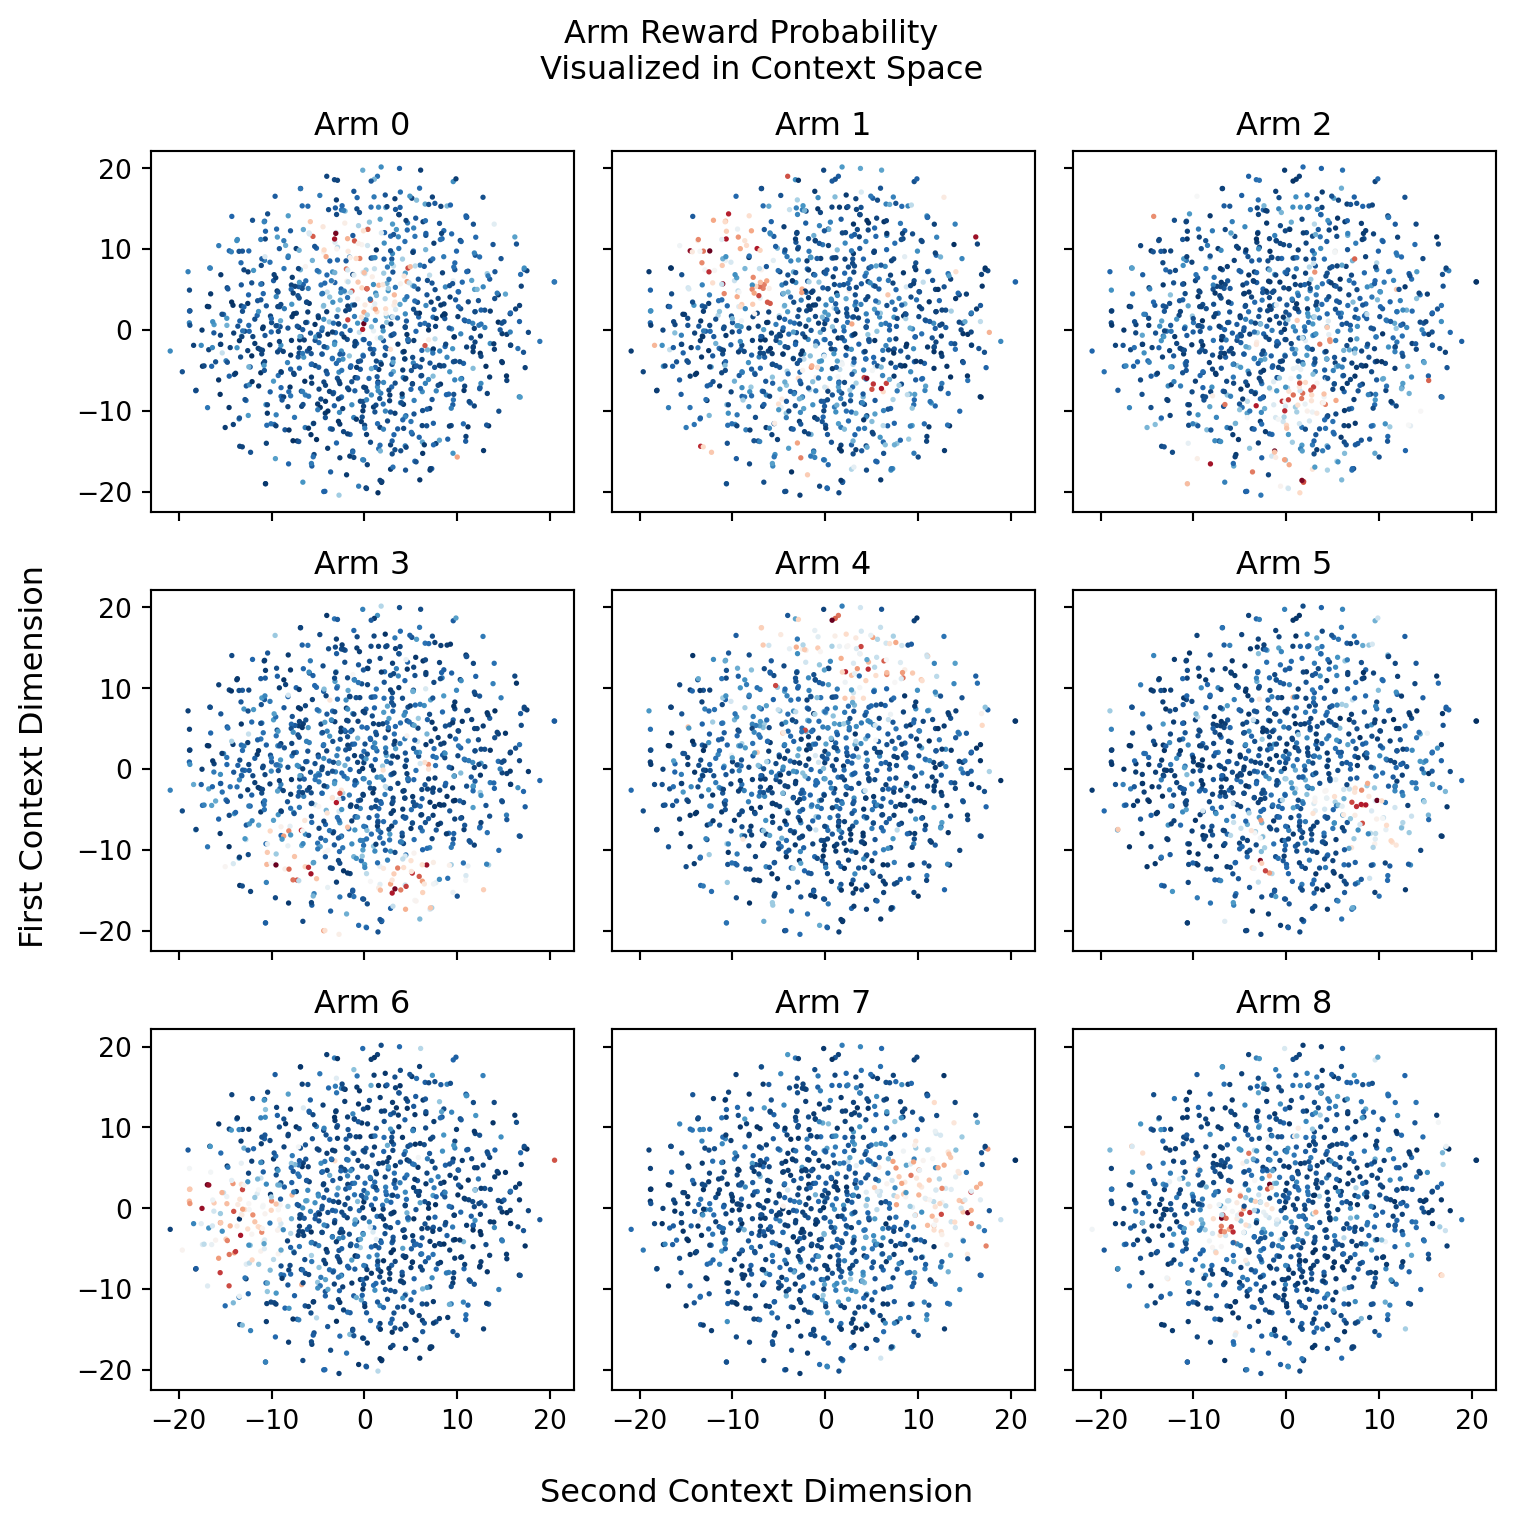

In [4]:
embedding = TSNE().fit_transform(CONTEXT[:, 0, :])

fig, axs = plt.subplots(UNIT_ARMS, UNIT_ARMS, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.flatten()
for arm in range(ARMS_PROBAILITIES.shape[1]):

    axs[arm].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=ARMS_PROBAILITIES[:, arm],
        s=1,
        cmap="RdBu_r"
    )
    axs[arm].set_title(f"Arm {arm}")

fig.supylabel("First Context Dimension")
fig.supxlabel("Second Context Dimension")
fig.suptitle("Arm Reward Probability \n Visualized in Context Space")
plt.tight_layout()
plt.show()

In [5]:
def init_matrices(context_size: int) -> Tuple[ArrayLike, ...]:
    A = jnp.eye(N=context_size)
    b = jnp.zeros(shape=(context_size, 1))
    return A, b

def init_matrices_for_all_arms(
        number_of_arms: int, 
        context_size: int,
    )  -> Tuple[ArrayLike, ...]:

    arms_A = []
    arms_b = []
    for _ in range(number_of_arms):

        A, b = init_matrices(context_size=context_size)
        arms_A.append(A)
        arms_b.append(b)

    arms_A = jnp.array(arms_A)
    arms_b = jnp.array(arms_b)

    return arms_A, arms_b

In [6]:
@jit
def compute_theta(
        A_inverse: ArrayLike, 
        b: ArrayLike,
    ) -> ArrayLike:

    theta = jnp.dot(A_inverse, b)
    return theta

@jit
def compute_sigma(
        context: ArrayLike, 
        A_inverse: ArrayLike,
    ) -> ArrayLike:

    sigma = jnp.sqrt(
        jnp.dot(
            jnp.transpose(context), 
            jnp.dot(A_inverse, context)
        )
    )
    return sigma

@jit
def compute_mu(
        theta: ArrayLike, 
        context: ArrayLike,
    )-> ArrayLike:

    mu = jnp.dot(
        jnp.transpose(theta),
        context
    )
    return mu

@jit
def compute_upper_bound(
        A: ArrayLike, 
        b: ArrayLike, 
        context: ArrayLike, 
        alpha: float,
    ) -> ArrayLike:
    A_inverse = inv(A)
    context_column = jnp.reshape(a=context, newshape=(-1, 1))

    theta = compute_theta(
        A_inverse=A_inverse, 
        b=b
    )
    sigma = compute_sigma(
        context=context_column, 
        A_inverse=A_inverse
    )
    mu = compute_mu(
        theta=theta, 
        context=context_column
    )
    upper_bound = mu + (sigma * alpha)
    return upper_bound

@jit
def execute_linucb(
        alpha: float, 
        arms_A: ArrayLike, 
        arms_b:ArrayLike, 
        context: ArrayLike, 
        noise: ArrayLike,
    ) -> ArrayLike:
    partialized_compute_upper_bound = partial(
        compute_upper_bound,
        alpha=alpha
    )
    upper_bound = vmap(
        fun=vmap( 
            fun=partialized_compute_upper_bound, 
            in_axes=(0, 0, 0)
        ),
        in_axes=(None, None, 0)
    )(arms_A, arms_b, context).squeeze()
    upper_bound += noise
    return upper_bound

In [7]:
@jit
def update_parameters(
    arms_A: ArrayLike, 
    arms_b: ArrayLike, 
    arms_context: ArrayLike, 
    policy: ArrayLike, 
    reward: ArrayLike
) -> Tuple[ArrayLike, ArrayLike]:
    new_A=arms_A[policy, :, :] 
    new_b=arms_b[policy, :, :]
    context=arms_context[policy, :]

    context_column = jnp.reshape(a=context, newshape=(-1, 1))
    new_A += jnp.dot(context_column, jnp.transpose(context_column))
    new_b += reward*context_column

    arms_A = arms_A.at[policy, :, :].set(new_A)
    arms_b = arms_b.at[policy, :, :].set(new_b)
    return arms_A, arms_b

In [8]:
@jit
def step(
        policy: ArrayLike, 
        arms_probabilities: ArrayLike, 
        step_key: ArrayLike, 
        reward_sparsity: ArrayLike
    ) -> ArrayLike:
    sparsity_key, reward_key = random.split(step_key)
    rows = jnp.arange(start=arms_probabilities.shape[0])

    sparsity_factor = random.bernoulli(
        key=sparsity_key,
        p=1 - reward_sparsity,
        shape=(arms_probabilities.shape[0],),
    ) * 1
    rewards = random.bernoulli(
        key=reward_key,
        p=arms_probabilities[rows, policy]
    ) * 1
    return rewards * sparsity_factor

@jit
def execute_policies(
        upper_bound: ArrayLike, 
        random_arm_key: ArrayLike,
    ) -> Tuple[ArrayLike, ArrayLike]:
    random_policy  = random.choice(
        key=random_arm_key, 
        a=jnp.arange(upper_bound.shape[1]),
        shape=(upper_bound.shape[0],)
    )
    linucb_policy = upper_bound.argmax(axis=1)
    return linucb_policy, random_policy

@jit
def compute_rewards(
        linucb_policy: ArrayLike, 
        random_policy: ArrayLike, 
        arms_probabilities: ArrayLike, 
        reward_sparsity: ArrayLike, 
        step_key
    ) -> ArrayLike:
    arms_rewards = []
    for policy in [linucb_policy, random_policy]:

        rewards = step(
            policy=policy, 
            arms_probabilities=arms_probabilities, 
            reward_sparsity=reward_sparsity,
            step_key=step_key
        )
        arms_rewards.append(rewards)

    return arms_rewards

@jit
def compute_regrets(
        linucb_policy: ArrayLike, 
        random_policy: ArrayLike, 
        arms_probabilities: ArrayLike
    ) -> List[ArrayLike]:
    policies_regrets = []
    optimality = arms_probabilities.max(1)
    rows = jnp.arange(start=arms_probabilities.shape[0])
    for policy in [linucb_policy, random_policy]:

        regret = optimality - arms_probabilities[rows, policy]
        policies_regrets.append(regret)
    
    return policies_regrets

@jit
def simulate_interaction(
        carry: Tuple[ArrayLike, ...], 
        x: Any, 
        arms_probabilities: ArrayLike, 
        alpha: float, 
        reward_sparsity: float
    ) -> Any:
    split_key, arms_A, arms_b, context = carry
    noise_key, random_arm_key, step_key, split_key = random.split(split_key, 4)  
    noise = random.normal(
        key=noise_key, 
        shape=(context.shape[0], arms_A.shape[0])
    ) * 1e-5

    upper_bound = execute_linucb(
        alpha=alpha, 
        arms_A=arms_A, 
        arms_b=arms_b, 
        context=context, 
        noise=noise,
    )
    linucb_policy, random_policy= execute_policies(
        upper_bound=upper_bound, 
        random_arm_key=random_arm_key
    )
    linucb_rewards, random_rewards = compute_rewards(
        linucb_policy=linucb_policy, 
        random_policy=random_policy, 
        arms_probabilities=arms_probabilities, 
        reward_sparsity=reward_sparsity,
        step_key=step_key
    )
    linucb_regrets, random_regrets = compute_regrets(
        linucb_policy=linucb_policy, 
        random_policy=random_policy, 
        arms_probabilities=arms_probabilities
    )

    arms_A, arms_b = vmap(
        fun=update_parameters, 
        in_axes=(None, None, 0, 0, 0)
    )(arms_A, arms_b, context, linucb_policy, linucb_rewards)
    arms_A = arms_A.mean(0)
    arms_b = arms_b.mean(0)

    new_carry = (split_key, arms_A, arms_b, context)
    diagnostics = {
        "linucb": {"rewards": linucb_rewards, "regrets": linucb_regrets}, 
        "random": {"rewards": random_rewards, "regrets": random_regrets}
    }

    return new_carry, diagnostics

In [9]:
SIMULATION_STEPS = (24 * 4) * 7

split_key = random.PRNGKey(666)
arms_A, arms_b = init_matrices_for_all_arms(
    number_of_arms=N_ARMS, 
    context_size=CONTEXT_SIZE
)

partialized_simulate_interaction = partial(
    simulate_interaction, 
    arms_probabilities=ARMS_PROBAILITIES, 
    alpha=1,
    reward_sparsity=REWARD_SPARSITY
)
carry, diagnostics = scan(
    partialized_simulate_interaction, 
    init=(split_key, arms_A, arms_b, CONTEXT),
    xs=jnp.arange(SIMULATION_STEPS)
)

In [10]:
#| code-fold: true
#| code-summary: "Show supplementary code"
def compute_diagnostics_summaries(diagnostics):
    diagnostics_summaries = {}
    for policy, diagnositcs_dict in diagnostics.items():

        diagnostics_summaries[policy] = {}

        for diagnostic, value in diagnositcs_dict.items():

            cumsum_value = value.cumsum(0)

            diagnostics_summaries[policy][diagnostic] = {
                "mean": value.mean(1), 
                "upper_percentile": np.percentile(value, 2.5, axis=1), 
                "lower_percentile": np.percentile(value, 97.5, axis=1), 
                "cumsum_mean": cumsum_value.mean(1), 
                "cumsum_upper_percentile": np.percentile(cumsum_value, 2.5, axis=1),
                "cumsum_lower_percentile": np.percentile(cumsum_value, 97.5, axis=1)
            }
    return diagnostics_summaries
 
def plot_diagnositc(mean, lower_percentile, upper_percentile, ax, label):
    ax.plot(
        mean,
        label=label
    )
    ax.fill_between(
        x=np.arange(mean.shape[0]),
        y1=lower_percentile,
        y2=upper_percentile,
        alpha=0.25
    )
    return ax

def plot_all_diagnostics(diagnostics_summaries, figsize=(10, 20)):
    fig, axs = plt.subplots(
        nrows=2, 
        ncols=2, 
        figsize=figsize, 
        sharex=True
    )
    axs = axs.flatten()

    for policy in list(diagnostics_summaries.keys()):

        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["rewards"]["mean"], 
            lower_percentile=diagnostics_summaries[policy]["rewards"]["upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["rewards"]["lower_percentile"], 
            ax=axs[0], 
            label=policy
        )
        ax.set_ylabel("Reward")
        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["rewards"]["cumsum_mean"], 
            lower_percentile=diagnostics_summaries[policy]["rewards"]["cumsum_upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["rewards"]["cumsum_lower_percentile"], 
            ax=axs[1], 
            label=policy
        )
        ax.set_ylabel("Cumulative Reward")

        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["regrets"]["mean"], 
            lower_percentile=diagnostics_summaries[policy]["regrets"]["upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["regrets"]["lower_percentile"], 
            ax=axs[2], 
            label=policy
        )
        ax.set_ylabel("Regret")
        ax.set_xlabel("Simulation Step")
        
        ax = plot_diagnositc(
            mean=diagnostics_summaries[policy]["regrets"]["cumsum_mean"], 
            lower_percentile=diagnostics_summaries[policy]["regrets"]["cumsum_upper_percentile"], 
            upper_percentile=diagnostics_summaries[policy]["regrets"]["cumsum_lower_percentile"], 
            ax=axs[3], 
            label=policy
        )
        ax.set_ylabel("Cumulative Regret")
        ax.set_xlabel("Simulation Step")

    for ax in axs:

        ax.grid()
        ax.legend()
    
    return fig, axs

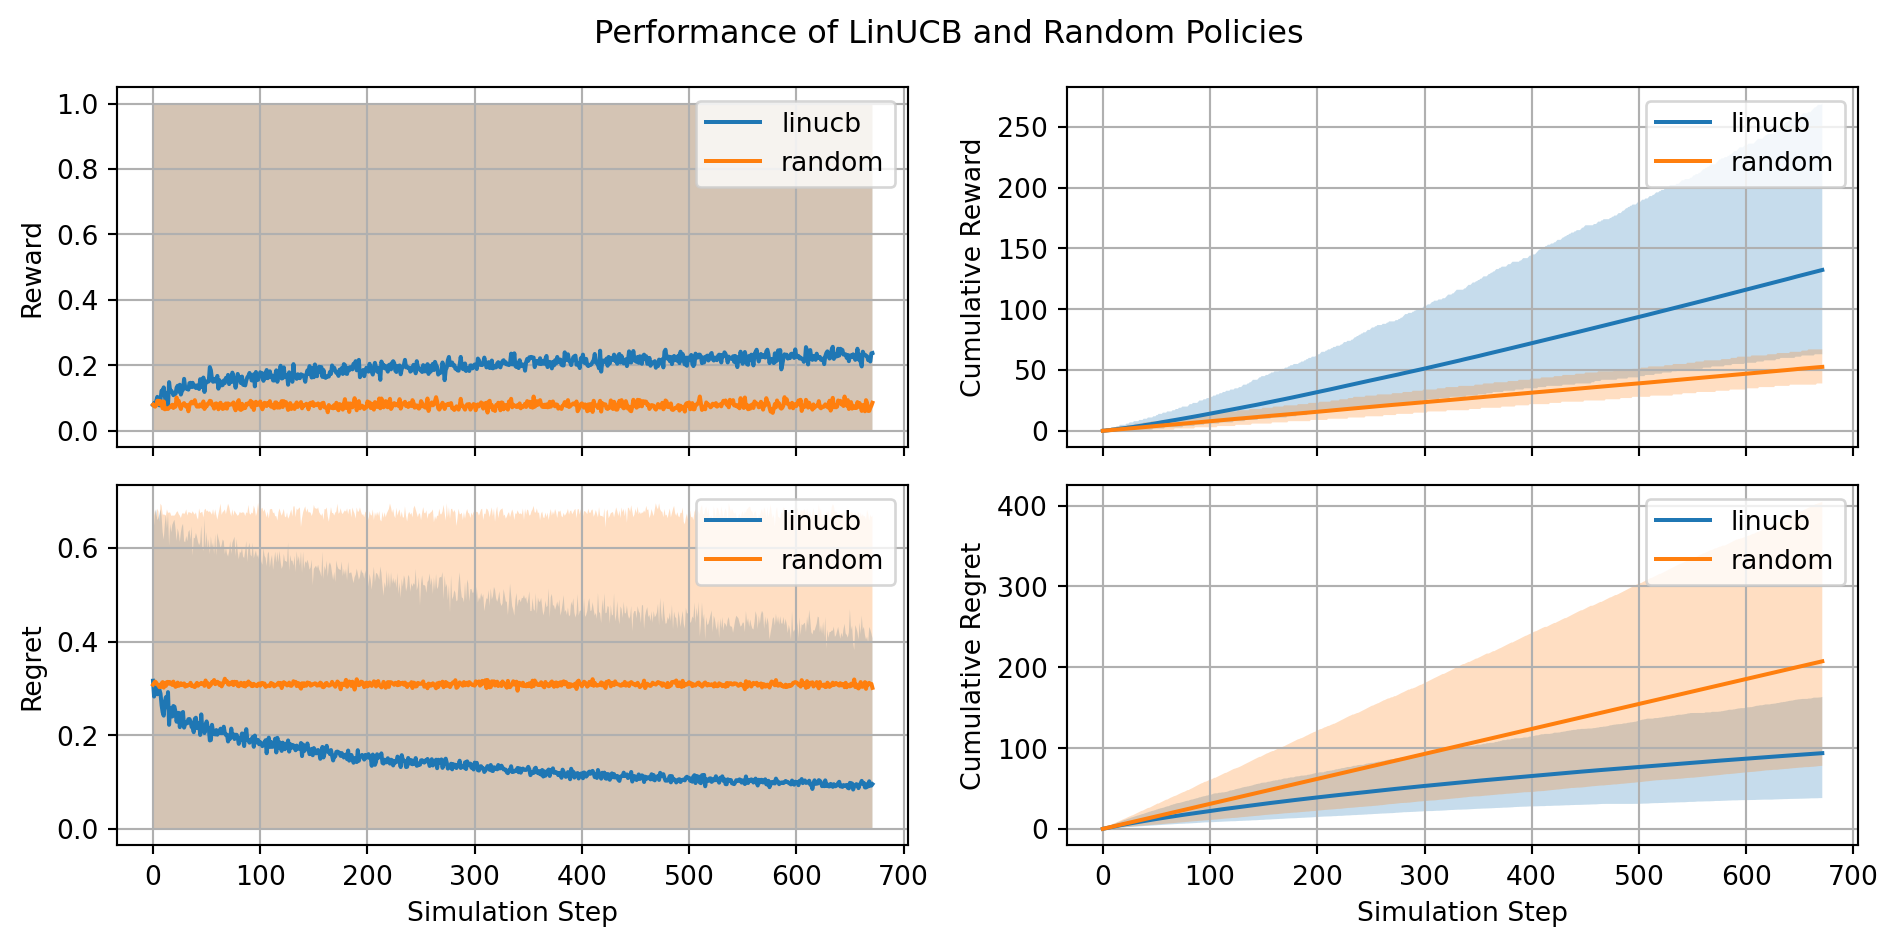

In [11]:
diagnostics_summaries = compute_diagnostics_summaries(
    diagnostics=diagnostics
)
fig, axs = plot_all_diagnostics(
    diagnostics_summaries=diagnostics_summaries, 
    figsize=(10, 5)
)
plt.suptitle("Performance of LinUCB and Random Policies")
plt.tight_layout()
plt.show()